# toy MC generator



In [1]:
# imports and configuration
%cd '/home/naodell/work/CMS/z_plus_jpsi'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline

/home/naodell/work/CMS/z_plus_jpsi


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'data/templates/bayesian_block_baseline/'
selections = ['mumu', 'mutau', 'mu4j', 'emu', 'ee', 'etau', 'e4j']
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'lepton2_pt', #'dilepton1_pt_asym', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )

fit_data = dict(selections=selections, n_selections=len(selections))
decay_map = pd.read_csv('data/decay_map.csv').set_index('id')
for selection in selections:
    fit_data[selection] = fh.get_template_data(input_dir, targets[selection], selection)

In [3]:
# generate scan values for tau branching fraction (b_e, b_mu, beta_tau, beta_h)
br_tau = [0.1783, 0.1741, 0.6476]
beta_scan_vals = ScanParameters(['beta_e', 'beta_mu', 'beta_tau'], 
                                [(0.104, 0.112), (0.104, 0.112), (0.104, 0.112)], 
                                [20, 20, 20]
                                )
sv = np.array(beta_scan_vals.get_scan_vals()[0])
beta_h = np.transpose([1 - np.sum(sv, axis=1)])
sv = np.hstack((sv, beta_h))

#sv = np.array([0.108*np.ones(50), 0.108*np.ones(50), np.arange(0.105, 0.1148, 0.0002), np.ones(50)])
#sv[3] -= np.sum(sv[:3], axis=0)
#sv = sv.transpose()

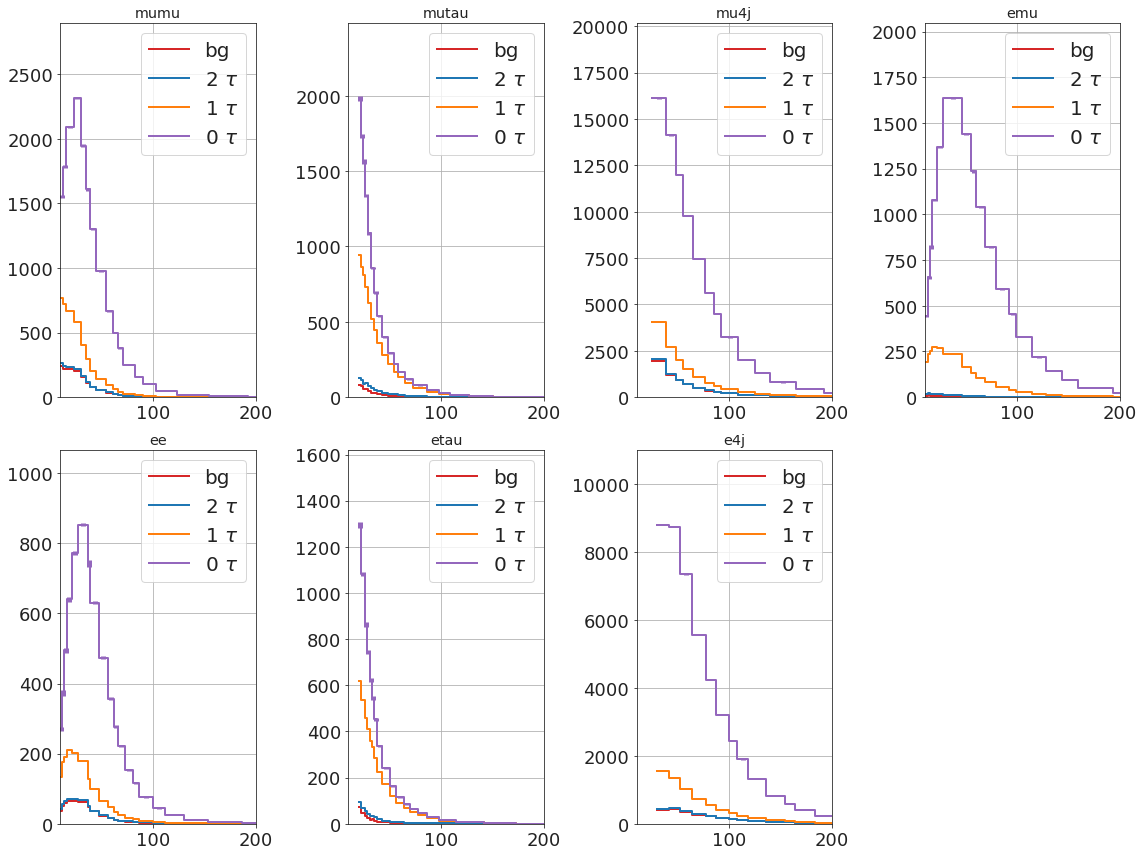

In [5]:
# generate toy MC samples and produce some validation plots

samples = {}
fig, axes = plt.subplots(2, 4, figsize=(16, 12), facecolor='white')
for i, selection in enumerate(selections):
    
    # signal component
    templates = fit_data[selection]['signal']
    signal_toys = [fh.signal_mixture_model(v, br_tau, (templates[0], np.sqrt(templates[0])), add_noise=True)[0] for v in sv]
    
    # add bg component
    bg = fit_data[selection]['bg']
    bg_toys = [bg[0] + np.sqrt(bg[1])*np.random.randn(bg[0].size) for _ in sv]
    
    # mixture
    samples[selection] = [s+b for s,b in zip(signal_toys, bg_toys)]
    
    # validation plot
    br = 0.108
    h_notau   = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, templates, mask=decay_map['sig_twotau']) + bg[0]
    h_onetau  = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, templates, mask=decay_map['sig_onetau']) + h_notau
    #h_twotau  = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, templates, mask=decay_map['sig_twotau']) + h_onetau
    h_nominal = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, templates) + bg[0]

    bins = fit_data[selection]['bins']
    dx = (bins[1:] - bins[:-1])
    dx = np.append(dx, dx[-1]) 
    x = bins + dx/2            

    ix, iy = int(i/4), int(i%4)
    ax = axes[ix][iy]
    
    #for s, b in zip(samples[selection][::10], bg_toys[::10]):
    #    ax.plot(bins, s/dx, drawstyle='steps-post', c='C9', alpha=0.9, linewidth=1.)
    #    ax.plot(bins, b/dx, drawstyle='steps-post', c='C1', alpha=0.9, linewidth=1.)
        
    ax.plot(bins, bg[0]/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2.)
    ax.plot(bins, h_notau[0]/dx, drawstyle='steps-post', c='C0', linestyle='-', linewidth=2.)
    ax.plot(bins, h_onetau[0]/dx, drawstyle='steps-post', c='C1', linestyle='-', linewidth=2.)
    ax.plot(bins, h_nominal[0]/dx, drawstyle='steps-post', c='C4', linestyle='-', linewidth=2.)
    ax.errorbar(x, h_nominal[0]/dx, np.sqrt(h_nominal[1])/dx,
                fmt        = 'C4.',
                capsize    = 0,
                markersize = 0,
                elinewidth = 5,
                alpha = 1.,   
               )

    xmin, xmax = bins[0]-dx[0], bins[-1]+dx[-1]
    ax.set_yscale('log')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(0.75*np.min(h_nominal[0]/dx), 1.25*np.max(h_nominal[0]/dx))
    ax.set_title(selection)
    ax.grid()
    
    ax.legend(['bg', r'2 $\tau$', r'1 $\tau$', r'0 $\tau$'])
    
axes[-1][-1].axis('off')
plt.tight_layout()
plt.show()

In [6]:
# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
mask      = [0, 0, 0, 0]
beta_init = [0.108, 0.108, 0.108, 1 - 3*0.108] # lepton universality (lep average)
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]
br_tau    = [0.1783, 0.1741, 0.6476]
p_init    = dict(vals = np.array(beta_init),
                 var  = np.array(var_beta),
                 mask = np.array(mask)
                )

fit_data['br_tau']       = br_tau
fit_data['p_init']       = p_init
fit_data['bounds']       = 3*[(0.1, 0.12), ] + [(0.65, 0.7)]
fit_data['constraints']  = [
                            dict(type = 'eq', fun = partial(fh.param_constraint_unitary, ix_beta=0)),
                            #dict(type = 'eq', fun = fh.param_constraint_prior)
                           ]

In [7]:
# Carry out the fits
results = []
dchi2 = []
new_samples = [{sel:samples[sel][i] for sel in selections} for i in range(len(sv))]
for sample in tqdm_notebook(new_samples):
    result = minimize(fh.alternative_cost, fit_data['p_init']['vals'],
                      method      = 'TNC',
                      bounds      = fit_data['bounds'],
                      constraints = fit_data['constraints'],
                      args        = (fit_data, sample, True)
                     ) 
    results.append(result.x)
    dchi2.append(fh.alternative_cost(beta_init, fit_data, sample, True) - result.fun)
    #f_cost = partial(fh.mixture_cost, fit_data=fit_data)
    #sig, corr_matrix = fh.calculate_covariance(f_cost, result.x)
    
dchi2 = np.array(dchi2)
results = np.array(results)
#results = np.apply_along_axis(lambda x: x/x.sum(), 1, results)

HBox(children=(IntProgress(value=0, max=8000), HTML(value='')))

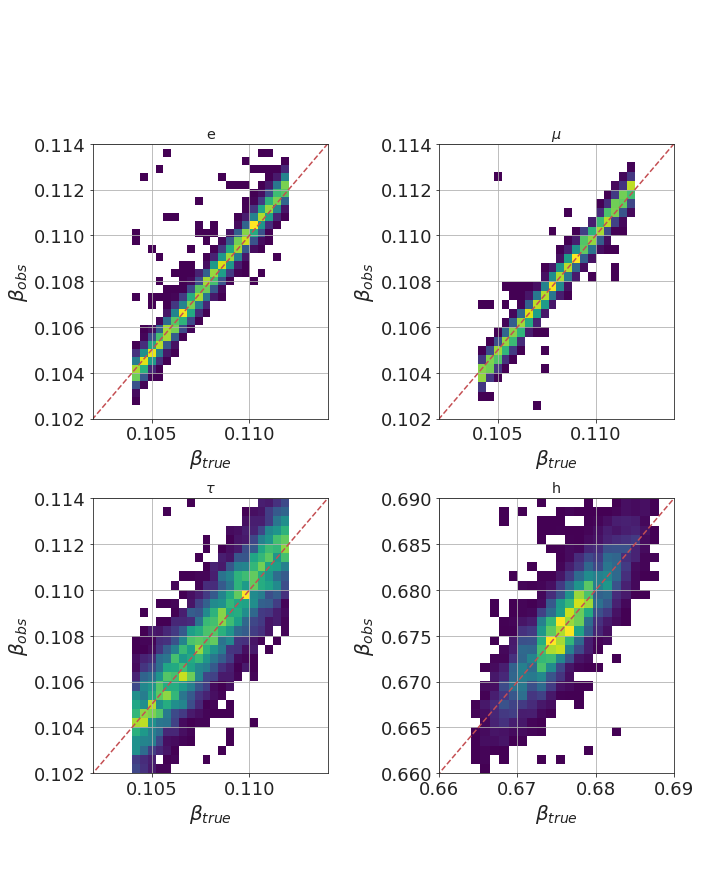

In [8]:
# visualize the result
fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor='white')

labels = ['e', r'$\mu$', r'$\tau$', 'h']
for i, b in enumerate(labels):
    ix, iy = int(i/2), int(i%2)
    ax = axes[ix][iy]
    #ax.scatter(sv[:,i], results[:,i], c='k', marker='_', alpha=0.6)
    ax.hist2d(sv[:,i], results[:,i], bins=(20, 50), cmin=1.)
    ax.plot([0., 1.], [0., 1.], linestyle='--', c='r')
    
    if b == 'h':
        ax.set_ylim(0.66, 0.69)
        ax.set_xlim(0.66, 0.69)
    else:
        ax.set_ylim(0.102, 0.114)
        ax.set_xlim(0.102, 0.114)
        
    ax.grid()
    ax.set_title(b)
    ax.set_ylabel(r'$\beta_{obs}$')
    ax.set_xlabel(r'$\beta_{true}$')

plt.tight_layout()
plt.show()

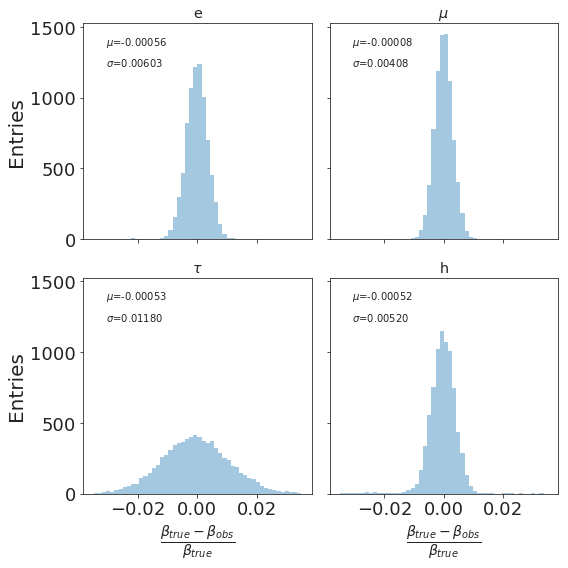

In [9]:
# biases
bias = np.transpose((sv - results)/sv)
fig, axes = plt.subplots(2, 2, figsize=(8, 8), facecolor='white', sharex=True, sharey=True)

for i, b in enumerate(bias):
    ix, iy = int(i/2), int(i%2)
    ax = axes[ix][iy]
    ax.hist(b, bins=50, range=(-0.035, 0.035), histtype='stepfilled', alpha=0.4)
    ax.text(0.1, 0.9,r'$\mu$={0:.5f}'.format(b.mean()), transform=ax.transAxes)
    ax.text(0.1, 0.8,r'$\sigma$={0:.5f}'.format(b.std()), transform=ax.transAxes)
    
    ax.set_title(labels[i])
    if iy == 0:
        ax.set_ylabel(r'Entries')
    
    if ix == 1:
        ax.set_xlabel(r'$\frac{\beta_{true} - \beta_{obs}}{\beta_{true}}$')

plt.tight_layout()
plt.show()

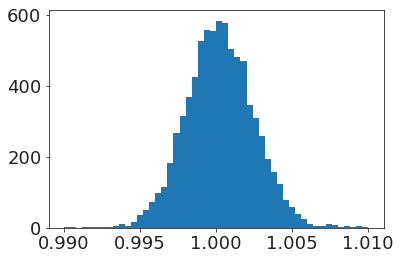

1.00048011423 0.00316922562142


In [10]:
total = results.sum(axis=1)
plt.hist(total, bins=50, range=(0.99, 1.01), histtype='stepfilled')
plt.show()

print(total.mean(), total.std())